# Wørdle sansynligheder på dansk

En undersøgelse af hvilke bogstaver der er mest forekomne i det danske sprog - og ikke mindst i 5 bogstavs ord.
Ligeledes gives et bud på de to første optimale gæt, samt sandsynlighede for antal rigtige bogstaver efter at disse to gæt er brugt.


In [1]:
from collections import Counter, OrderedDict

import pandas as pd

### Henter alle danske ord fra retskrivningsordbogen
Data er hentet fra Application Storage fra https://roplus.dk/#ordbog/ og skal således forbehandles

In [2]:
with open("ord.txt") as f:
    lines = f.readlines()
lines = lines[0].split("\\n")[4:]

In [3]:
ord = [l.split("\\")[0].lstrip("0123456789-") for l in lines]
ord = list(OrderedDict.fromkeys(ord))
len(ord)

63860

### Tæl bogstaver
I alt 63860 ord i ordbogen. Lad os tælle nogle bogstaver. Alle ord lægges i en DataFrame så de er nemmere at håndtere og optælle. Der oprettes en kolonne for hvert bogstav og der optælles hvor mange gange dette bogstav forekommer i ordet.

In [4]:
def letter_counts(s: str) -> dict:
    counts = Counter([l for l in s.lower()])
    return counts

In [5]:
%%time
df = pd.DataFrame(ord, columns=["ord"])
# Længde af ord samt optælling af bogstaver
df["len"] = df["ord"].str.len()
df["count"] = df["ord"].apply(letter_counts)
# Split dict til kolonner
df = pd.concat([df.drop(["count"], axis=1), df["count"].apply(pd.Series)], axis=1)
# Sorter bogstavskolonnerne
df = df[["ord", "len"] + [i for i in df.columns[2:].sort_values() if i.isalpha()]]

CPU times: user 5.48 s, sys: 119 ms, total: 5.59 s
Wall time: 5.6 s


In [6]:
df.sample(5)

,ord,len,a,b,c,d,e,f,g,h,...,v,w,x,y,z,å,æ,é,ø,ü
28821,Korea,5,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6002,branke,6,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53403,svineri,7,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1346,alfarvej,8,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55504,tilgang,7,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5 bogstavs ord
Lad os se på bogstavsfordelingen i 5 bogstavs ord

In [7]:
df[df["len"] == 5].shape

(3759, 33)

Dvs af de ~64.000 ord i retskrivningsordbogen er der 3759 ord med 5 bogstaver. Lad os se på en frekvensoptælling af bogstaverne.

<AxesSubplot:>

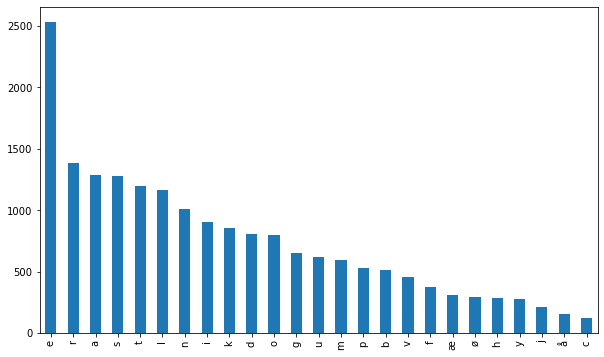

In [8]:
df[df["len"] == 5].iloc[:, 2:].sum().sort_values(ascending=False)[:25].plot.bar(
    figsize=(10, 6)
)

Dvs. de 10 mest almindelige bogstaver er e, r, a, s, t, l, n, i, k og d

Lad os se på fordelingen i alle andre ord som ikke har 5 bogstaver

<AxesSubplot:>

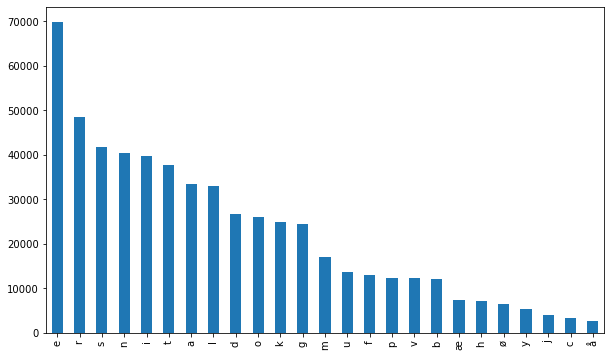

In [9]:
df[df["len"] != 5].iloc[:, 2:].sum().sort_values(ascending=False)[:25].plot.bar(
    figsize=(10, 6)
)

Interessant, et lidt andet billede. Vi fortsætter med fordelingen med 5 bogstavsord

Her er en funktion der returnerer alle 5 bogstavsord fra retskrivningsordbogen der indeholder de angivne bogstaver.

In [10]:
def check_letters(s: str, len: int = 5) -> str:
    res = []
    for i, row in df[df["len"] == len].iterrows():
        if set(sorted(s.lower())).issubset(sorted(row["ord"].lower())):
            res.append(row["ord"])
    return res

In [11]:
check_letters("erast")

['raste']

In [12]:
check_letters("lnik")

['blink', 'flink', 'inkl.', 'kline', 'klink', 'klint', 'linke']

Et god bud på de to første ord kunne være "raste" og "blink". Lad os undersøge hvor mange bogstaver vi vil have fundet hvis de to ord er de første to gæt.

In [13]:
def count_overlap(s1: str, s2: str) -> int:
    return len(set(s1) & set(s2))

In [14]:
df["raste"] = df.apply(lambda x: count_overlap(x["ord"], "raste"), axis=1)
df["blink"] = df.apply(lambda x: count_overlap(x["ord"], "blink"), axis=1)
df["top10"] = df["raste"] + df["blink"]

<AxesSubplot:>

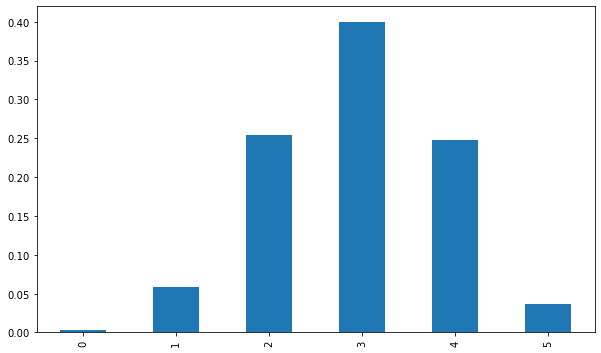

In [15]:
df[df["len"] == 5]["top10"].value_counts(normalize=True).sort_index().plot.bar(
    figsize=(10, 6)
)

In [16]:
df[df["len"] == 5]["top10"].value_counts(normalize=True).sort_index()[3:].sum()

0.6842245277999468

### Konklusion
Hvis de to første gæt er "raste" og "blink" vil du med 68% sandsynlighed have 3 eller flere rigtige bogstaver
